In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
sns.set()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Task 1: Descriptive statistics

**Task summary:**

*Perform EDA on the provided dataset.*

Let's load the dataset using pandas, view column summary and take a look at some example rows:

In [2]:
df = pd.read_csv('colleges-data.tsv', sep='\t')
df.head()

School School_Type   SAT  Acceptance  $/Student  Top 10%  %PhD  Grad%
0     Amherst    Lib Arts  1315          22      26636       85    81     93
1  Swarthmore    Lib Arts  1310          24      27487       78    93     88
2    Williams    Lib Arts  1336          28      23772       86    90     93
3     Bowdoin    Lib Arts  1300          24      25703       78    95     90
4   Wellesley    Lib Arts  1250          49      27879       76    91     86

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
School         50 non-null object
School_Type    50 non-null object
SAT            50 non-null int64
Acceptance     50 non-null int64
$/Student      50 non-null int64
Top 10%        50 non-null int64
%PhD           50 non-null int64
Grad%          50 non-null int64
dtypes: int64(6), object(2)
memory usage: 3.2+ KB


No missing (null) values to handle here.

Description provided with the dataset states that **School** can be treated as unique ID, **School_Type** as categorical variable and the rest of the features are numerical. Looks like it is really the case. Let's check **School** and **School_Type** values and their cardinality:

In [4]:
df.School.is_unique

True

In [5]:
SCHOOL_TYPES = list(df.School_Type.unique())    # will be used later
df['School_Type'].value_counts()

Lib Arts    25
Univ        25
Name: School_Type, dtype: int64

So our entries are divided into two categories (25 objects for each one).

Now let's inspect and visualize descriptive statistics that summarize the central tendency, dispersion and shape for numeric columns.

In [6]:
df.describe()

SAT  Acceptance      $/Student    Top 10%        %PhD  \
count    50.000000   50.000000      50.000000  50.000000   50.000000   
mean   1263.960000   37.840000   30247.200000  74.440000   90.560000   
std      62.329591   13.363612   15266.172682  13.515162    8.258972   
min    1109.000000   17.000000   17520.000000  47.000000   58.000000   
25%    1225.000000   25.750000   20182.250000  65.000000   86.250000   
50%    1264.000000   36.000000   24994.500000  76.500000   93.000000   
75%    1304.500000   47.750000   36803.750000  85.000000   97.750000   
max    1400.000000   67.000000  102262.000000  98.000000  100.000000   

           Grad%  
count  50.000000  
mean   83.480000  
std     7.557237  
min    61.000000  
25%    77.250000  
50%    85.500000  
75%    89.000000  
max    95.000000

Let's make box plots for all numeric columns.

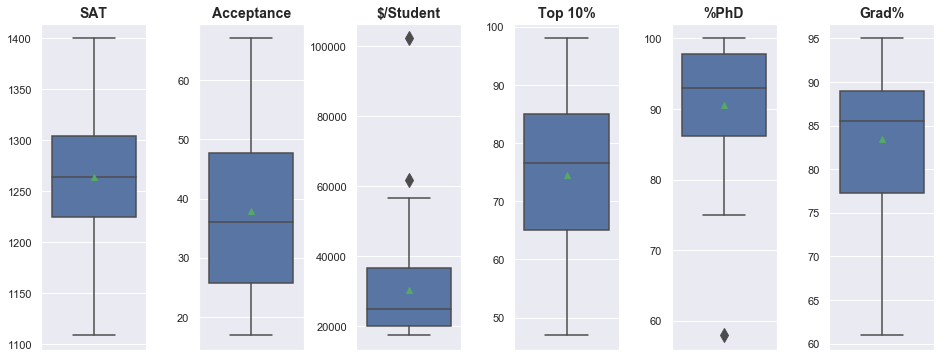

In [7]:
NUMERIC_COLS = ['SAT', 'Acceptance', '$/Student', 'Top 10%', '%PhD', 'Grad%']

def show_boxplot(df):
    f, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_COLS), figsize=(16, 6))
    plt.subplots_adjust(wspace=0.5)
    for index, column_name in enumerate(NUMERIC_COLS):
        sns.boxplot(data=df, y=column_name, ax=axes[index], fliersize=10, showmeans=True)
        axes[index].set_title(column_name, fontsize=14, fontweight='bold')
        axes[index].set_ylabel('')

show_boxplot(df)

We have few outliers in **\$\/Student** (money spent per student) and **\%PhD** (PhD percentage) columns.
It is hard to judge credibility of those values. Colleges that spend $100.000 per student or have 50% of PhD degrees may really exist. One way or another, let's remove these for further analysis as correlation coefficients are not robust to outliers. For the sake of simplicity we will use 3-sigmas method:

In [8]:
def remove_outlier_3sigmas(df, col_name):
    return df.loc[(np.abs(stats.zscore(df[col_name])) < 3)]

df_clean = df.copy()
for col_name in NUMERIC_COLS:
    df_clean = remove_outlier_3sigmas(df_clean, col_name)
    
print('Outliers removed:', len(df) - len(df_clean))

Outliers removed: 3


Let's see the boxplots for the cleaned dataset.

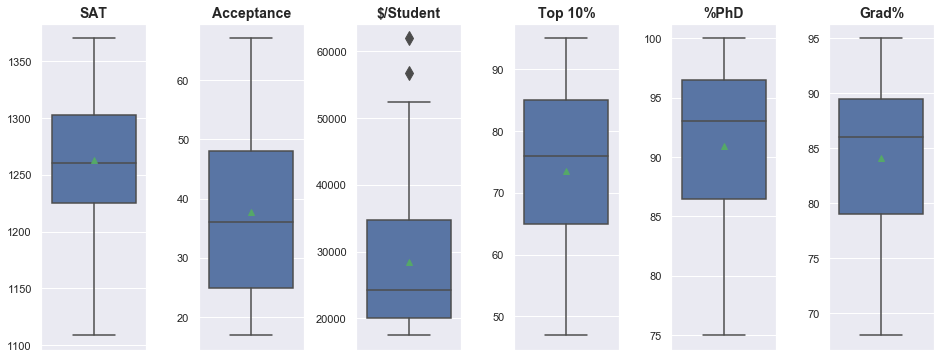

In [9]:
show_boxplot(df_clean)

Much better. Still distribution shapes are not immediately obvious from this. Let's see the histogram for each feature. Along with overall histogram we will plot per-category histograms and see what we can learn from them.

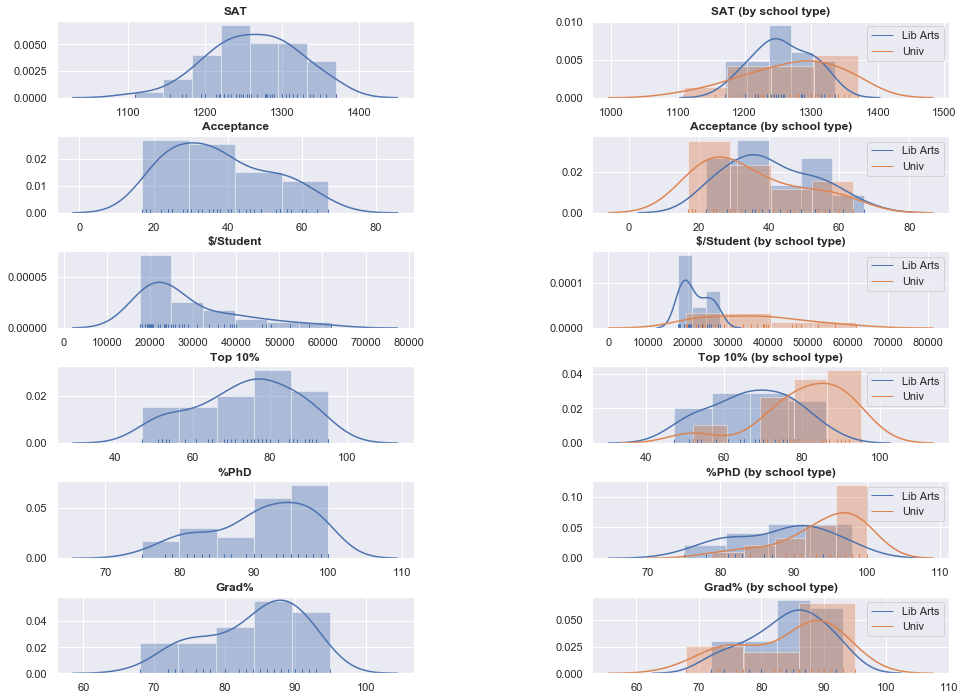

In [10]:
def plot_distributions(df):
    f, axes = plt.subplots(nrows=len(NUMERIC_COLS), ncols=2, figsize=(16, 12))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    for index, column_name in enumerate(NUMERIC_COLS):
        sns.distplot(df[column_name], ax=axes[index][0], rug=True)
        axes[index][0].set_title(column_name, fontsize=12, fontweight='bold')
        axes[index][0].set_xlabel('')
    
        for school_type in SCHOOL_TYPES:
            sns.distplot(df[df.School_Type == school_type][column_name], ax=axes[index][1], rug=True)

        axes[index][1].legend(SCHOOL_TYPES)
        axes[index][1].set_title('%s (by school type)' % column_name, fontsize=12, fontweight='bold')
        axes[index][1].set_xlabel('')

plot_distributions(df_clean)

All distributions are unimodal.
- **SAT**: follows normal distribution pretty well
- **Acceptance**: positively skewed bell shape
- **$\/Student**: positively skewed, does not really look like gaussian, but can be considered a mix of two gaussians (per **School_Type**)
- **Top 10\%**, **\%PhD**, **Grad%**: negatively skewed bell shape

As we could expect distribution parameters for all numeric columns depend on **School_Type**. This effect is most pronounced and visible for the variance of **$\/Student** column.

Now let's take a look at correlations on a pair plot:

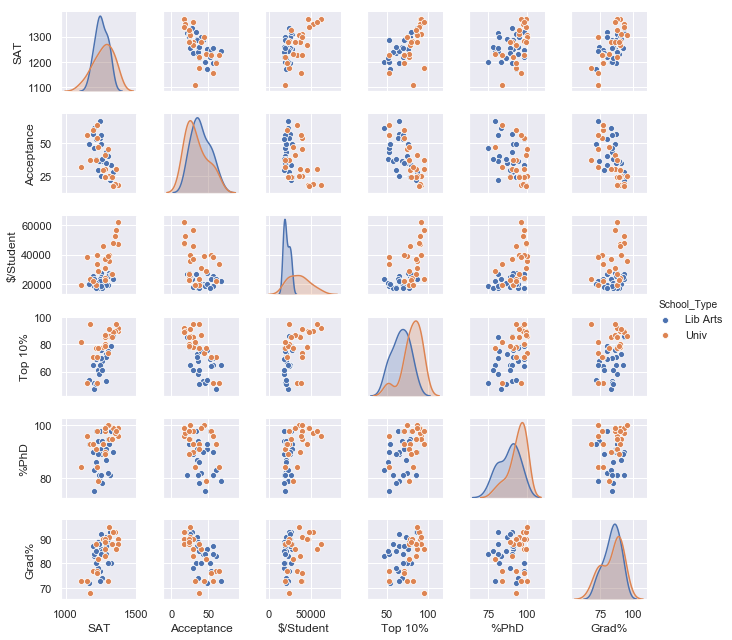

In [11]:
sns.pairplot(df_clean, hue='School_Type', height=1.5)
plt.show()

Some correlations clearly do exist but are hard to read on this chart. We don't see any weird shapes here, so let's consider correlations to be linear and inspect Pearson coefficients on a heatmap:

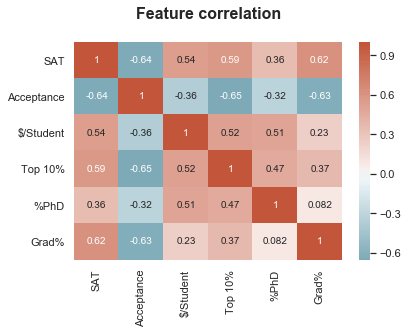

In [12]:
sns.heatmap(df_clean.corr(), center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True), annot=True)
plt.title('Feature correlation\n', fontsize=16, fontweight='bold')
plt.show()

The most obvious takeaway from this is that **Acceptance** ("% of applicants accepted") is negatively correlated with all features that represent some students' or teachers' skills, scores or achievements (**SAT**, **Top 10\%**, **Grad%**, **\%PhD**). Which is no wonder.

Also all these skill-related features are more-or-less correlated with others in this group. That is again something we could expect. **Grad%** and **\%PhD** pair is the only notable exception that shows no correlation at all.

Correlations for **$\/Student** ("money spent per student in dollars") allow very vague interpretations, partly because the exact meaning of this value is not clear from the description.

That's it for our brief EDA.

# Task 2: Stratified sampling

**Task summary:**

*Compare properties of point estimates of expected value and variance of a stratified population for different sampling methods, sample sizes and population distribution parameters.*

Let's begin with defining utility functions that we will use in the modeling process. We will represent stratified population as a DataFrame with two columns (stratum and some numeric value). Sampling methods will be implemented as functions that take that DataFrame and return a new DataFrame of exactly same column structure (a subset of its rows).

In [13]:
def generate_population(strata_params, size=10000):
    """Generate statistical population for further sampling.

    Args:
        strata_params (iterable of dicts): weights, means and variances for stratas
        size (int): size of the population
    Returns:
        DataFrame of shape (size, 2), columns: 'value', 'stratum'    
    """
    dfs = []
    for d in strata_params:
        dfs.append(
            pd.DataFrame({
                'stratum': d['name'],
                'value': np.random.normal(
                    loc=d['mean'], scale=d['std'],
                    size=int(np.round(size * d['weight']))
                )
            })
        )
    return pd.concat(dfs)

In [14]:
def sample_random(df, size, **kwargs):
    """Simple random sampling.
    
    Args:
        df (DataFrame): dataframe to sample from
        size (int): size of the sample
    Returns:
        DataFrame (sampled subset)
    """
    return df.sample(n=size)

In [15]:
def sample_prop(df, size, strata_params, col_name='stratum'):
    """Proportionate sampling.
    
    Args:
        df (DataFrame): dataframe to sample from
        size (int): size of the sample
        strata_params (iterable of dicts): weights, means and variances for stratas
        col_name: column indicating the stratum
    Returns:
        DataFrame (sampled subset)
    """
    n = df.shape[0]
    weights = {d['name']:d['weight'] for d in strata_params}
    return df.groupby(col_name).apply(
        lambda x: x.sample(n=int(np.round(size * weights[x.loc[0][col_name]])))
    )

In [16]:
def sample_optimum(df, size, strata_params, col_name='stratum'):
    """Optimum sampling.
    
    Args:
        df (DataFrame): dataframe to sample from
        size (int): size of the sample
        strata_params (iterable of dicts): weights, means and variances for stratas
        col_name: column indicating the stratum
    Returns:
        DataFrame (sampled subset)
    """
    n = df.shape[0]
    
    w_sigmas = {}
    for stratum_data in strata_params:
        w_sigmas[stratum_data['name']] = stratum_data['std'] * stratum_data['weight']
    sum_w_sigmas = sum(w_sigmas.values())
    weights = {k:v/sum_w_sigmas for k,v in w_sigmas.items()}
    
    return df.groupby(col_name).apply(
        lambda x: x.sample(n=int(np.round(size * weights[x.loc[0][col_name]])))
    )    

The following function will perform repeated sampling from a provided population using different set of strategies and sample sizes, calculate point estimates in question and stores them all in a report DataFrame (one row per sample).

In [17]:
SAMPLE_SIZES = (40, 500)

SAMPLING_STRATEGIES = {
    'random': sample_random,
    'prop': sample_prop,
    'optimum': sample_optimum,
}

def generate_report(population: pd.DataFrame, strata_params, num_samples=1000) -> pd.DataFrame:
    """
    Generate statistics report for given population using different
    sample sizes and sampling strategies.
    
    Args:
        population (DataFrame): statistical population to sample from
        strata_params (iterable of dicts): weights, means and variances for stratas
        num_samples (int): how many times to repeat sampling for any particular set of parameters
    Returns:
        DataFrame (sampling report with sampling parameters and mean/variance estimates)
    """
    report = pd.DataFrame()

    for sample_size, strategy in itertools.product(SAMPLE_SIZES, SAMPLING_STRATEGIES.keys()):
        sampling_func = SAMPLING_STRATEGIES[strategy]

        means = []
        stds = []
        for _ in range(num_samples):
            # Generate the sample
            sample = sampling_func(population, size=sample_size, strata_params=strata_params)
            
            # Estimate mean and standard deviation (according to sampling strategy)
            if strategy == 'random':
                mean = sample['value'].mean()
                std = sample['value'].std()
            elif strategy in ['prop', 'optimum']:
                weights = pd.Series({d['name']:d['weight'] for d in strata_params})

                mean_by_stratum = sample.groupby('stratum')['value'].mean()
                var_by_stratum = sample.groupby('stratum')['value'].var()
                
                mean = np.sum(mean_by_stratum * weights)
                var = (
                    np.sum(var_by_stratum * weights)
                    + np.sum(weights * (mean - mean_by_stratum) ** 2)
                )
                std = np.sqrt(var)
            else:
                raise ValueError('Unknown sampling strategy: %s', strategy)

            means.append(mean)
            stds.append(std)

        report = pd.concat([
            report,
            pd.DataFrame({
                'sample_size': sample_size,
                'strategy': strategy,
                'mean': means,
                'std': stds,
            }),
        ])
    return report

This one is used to plot the results.

In [18]:
def plot_report(report: pd.DataFrame, actual_mean=None, actual_std=None):
    """Plot statistics report using the boxplots.
    
    Args:
        report (DataFrame): sampling report (as returned by `generate_report`)
        actual_mean (float): mean of the population to plot (optional)
        actual_std (float): standard deviation of the population to plot (optional)
    Returns:
        None
    """
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    sns.boxplot(x="strategy", y="mean", hue='sample_size', data=report, ax=axes[0])
    sns.boxplot(x="strategy", y="std", hue='sample_size', data=report, ax=axes[1])
    
    if actual_mean:
        axes[0].axhline(actual_mean, 0, 1, color='green')
    if actual_std:
        axes[1].axhline(actual_std, 0, 1, color='green')
    
    axes[0].set_title('Mean', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Sampling strategy', fontsize=14)
    axes[0].set_ylabel('')
    axes[1].set_title('Standard deviation', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Sampling strategy', fontsize=14)
    axes[1].set_ylabel('')

Having written the utility code we can start generating various populations and compare sampling methods on them.

We assume that our population is comprised of three strata with different weights. Let's model three such populations.

### Population 1: matching expected values + matching variances

In [19]:
strata_params1 = (
    dict(name='0', mean=0, std=1, weight=0.5),
    dict(name='1', mean=0, std=1, weight=0.3),
    dict(name='2', mean=0, std=1, weight=0.2),
)
population1 = generate_population(strata_params1, size=10000)
report1 = generate_report(population1, strata_params1)

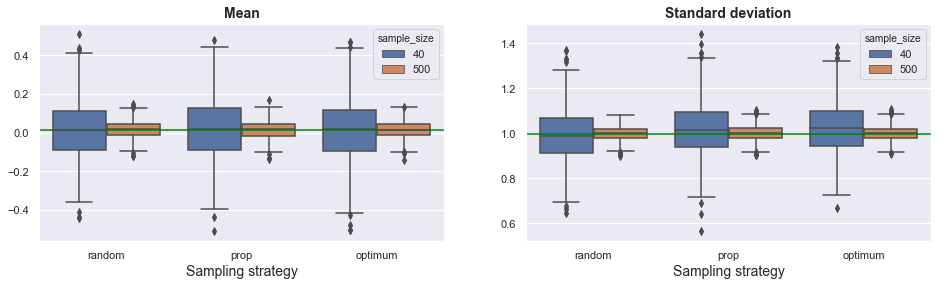

In [20]:
plot_report(report1, actual_mean=population1.value.mean(), actual_std=population1.value.std())

**Conclusion**

We see here that for such an edge case (equal expected values and variance for all stratas) proportionate or optimum sampling methods do not have any advantages over random sampling. They all do the same thing in the end of the day. 

### Population 2: different expected values + matching variances

In [21]:
strata_params2 = (
    dict(name='0', mean=0, std=1, weight=0.5),
    dict(name='1', mean=2, std=1, weight=0.3),
    dict(name='2', mean=4, std=1, weight=0.2),
)
population2 = generate_population(strata_params2, size=10000)
report2 = generate_report(population2, strata_params2)

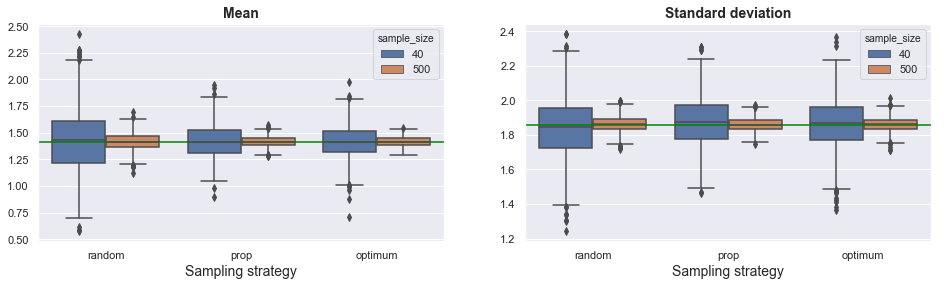

In [22]:
plot_report(report2, actual_mean=population2.value.mean(), actual_std=population2.value.std())

**Conclusion**

Here we see a different picture. All the stratas have the same variance, so proportional and optimum sampling are technically equivalent here, and both converge to the true value of the estimated parameter much faster than random sampling (thus requiring fewer sample sizes for the same estimation accuracy).

### Population 3: different expected values + different variances

In [23]:
strata_params3 = (
    dict(name='0', mean=0, std=0.5, weight=0.5),
    dict(name='1', mean=10, std=2, weight=0.3),
    dict(name='2', mean=20, std=8, weight=0.2),
)
population3 = generate_population(strata_params3, size=10000)
report3 = generate_report(population3, strata_params3)

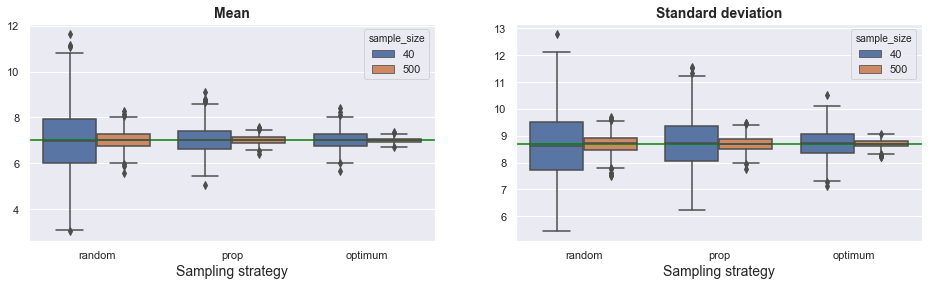

In [24]:
plot_report(report3, actual_mean=population3.value.mean(), actual_std=population3.value.std())

**Conclusion**

When both means and variance differ across the stratas optimum sampling does its best. It converges faster than proportionate sampling which in its turn does it faster than random sampling.

Anyway all three converge to the same values (just as in two previous cases).

# Task 3: Wald's Sequential Probability Ratios Test (SPRT)

**Task summary:**

*Investigate the behavior of SPRT test on stratified synthetic dataset and tell how required sample size depends on the strata weights and desired type I and type II error rate.*

First, we will write the function to generate samples from statistical population which is comprised of two stratas with different means and weights and matching variances.

In [25]:
def get_sample(means, weights, std=1, size=1000):
    """Get sample from a population.
    
    Args:
        means (sequence of ints): means of stratas
        weights (sequence of ints): weights of stratas
        std (float): standard deviation (shared between stratas)
        size (int): sample size
    Returns:
        numpy.ndarray of shape (size, 1)    
    """
    sample = np.concatenate([
        np.random.normal(loc=mean, scale=std, size=int(np.round(weight * size)))
        for mean, weight in zip(means, weights)
    ])
    np.random.shuffle(sample)
    return sample

Next, we need a function that will conduct SPRT test on a sample and check hypotheses about the mean values of the population. It will return the decision (reject H0 or not) and the number of steps required to reach that decision.

Exact description of method used: https://en.wikipedia.org/wiki/Sequential_probability_ratio_test

In [26]:
def sprt_mean_test(sample, a0, a1, std=1, alpha=0.1, beta=0.1):
    """
    Conduct SPRT test on provided sample from the population.
    Null hypothesis - mean of the population is a0.
    Alternative hypothesis - mean of the population is a1
    
    Args:
        sample (numpy.ndarray): sample from the population
        a0 (float): mean for null hypothesis
        a1 (float): mean for alternative hypothesis
        std (float): standard deviation (shared between stratas)
        alpha (float): desired Type I error rate
        beta (float): desired Type II error rate    
    Returns:
        tuple of size 2:
            reject H0 (boolean): reject H0 or not
            num_steps (int): number of iterations in the test    
    """
    a = np.log(beta / (1 - alpha))
    b = np.log((1 - beta) / alpha)
    s = 0

    for step, x in enumerate(sample):
        log_likelihood_ratio = np.log(     
            stats.norm.pdf(x, loc=a1, scale=std)
            / stats.norm.pdf(x, loc=a0, scale=std)
        )
        s = s + log_likelihood_ratio
        if s <= a:
            return False, step      # reject H1, accept H0
        elif s >= b:
            return True, step      # reject H0, accept H1
    raise ValueError('Ran out of sample size.')

Next, we need to generate samples and conduct SPRT test for different strata weights and desired error rates and plot the results.

In [27]:
def generate_sprt_report(a0, a1, alpha=0.1, beta=0.1):
    """
    Repeat sample generation and hypothesis testing with different parameters.
    
    Args:
        a0 (float): mean for null hypothesis
        a1 (float): mean for alternative hypothesis
        alpha (float): desired Type I error rate
        beta (float): desired Type II error rate
    Returns:
        pandas.DataFrame
        (report object with params and results for each test)
    """
    sprt_report = pd.DataFrame()

    # Vary weights from 0% to 100% with 25% step.
    for weight in np.linspace(0, 1, num=5):
        decision_array = []
        num_steps_array = []
        
        # Repeat the experiment multiple times for each weight
        for _ in range(1000):
            sample = get_sample([a0, a1], [weight, 1 - weight])
            decision, num_steps = sprt_mean_test(sample, a0, a1, alpha=alpha, beta=beta)
            decision_array.append(decision)
            num_steps_array.append(num_steps)
            sprt_report = pd.concat([
                sprt_report,
                pd.DataFrame({
                    'weight': weight,
                    'decision': decision_array,
                    'num_steps': num_steps_array,
                })
            ])
    return sprt_report

The main thing we want to investigate is the number of steps required for the test to stop. We will plot them using boxplots (separately for each weight)

In [53]:
def plot_sprt_report(report):
    """
    Plot the report using boxplots.
    
    Args:
        report (pandas.DataFrame): report object generated on the previous steps.
    Returns:
        None
    """
    
    g = sns.boxplot(x="weight", y="num_steps", showmeans=True, data=report)
    g.set_title('SPRT report', fontsize=16, fontweight='bold')
    g.set_xlabel('Weight', fontsize=14)
    g.set_ylabel('Number of steps', fontsize=14)

def get_num_steps_means(report):
    """Return dataframe with mean number of steps by weight."""
    return pd.DataFrame(report.groupby('weight')['num_steps'].mean())

Also it is useful to check actual Type I/II error rates (to make sure everything works correctly). The code is pretty straightforward (but we use only 0% and 100% weights for this estimation because the error rates on mixed samples are harder to define).

In [29]:
def print_error_rates(report):
    """
    Calculate end print Type I/II error rates.
    
    Args:
        report (pandas.DataFrame): report object generated on the previous steps.
    Returns:
        None

    """
    h0_subset = report[report.weight > 0.99]
    h1_subset = report[report.weight < 0.01]
    
    type1_error_rate = len(h0_subset[h0_subset.decision == True]) / len(h0_subset)
    type2_error_rate = len(h1_subset[h1_subset.decision == False]) / len(h1_subset)

    print('Type I error rate: %.3f' % type1_error_rate)
    print('Type II error rate: %.3f' % type2_error_rate)

Having done that, let's conduct two experiments with different error rates.

### First experiment (bigger error rates)

In [50]:
sprt_report1 = generate_sprt_report(a0=1, a1=1.5, alpha=0.05, beta=0.1)

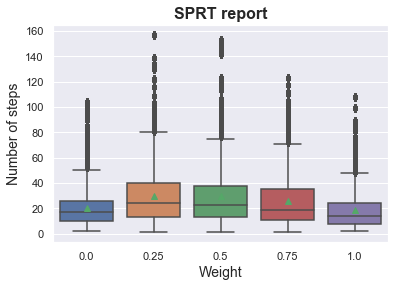

In [62]:
plot_sprt_report(sprt_report1)

In [63]:
get_num_steps_means(sprt_report1)

num_steps
weight           
0.00    20.497808
0.25    29.707566
0.50    29.797872
0.75    26.062350
1.00    18.525249

In [64]:
print_error_rates(sprt_report1)

Type I error rate: 0.037
Type II error rate: 0.086


### Second experiment (smaller error rates)

In [33]:
sprt_report2 = generate_sprt_report(a0=1, a1=1.5, alpha=0.02, beta=0.01)

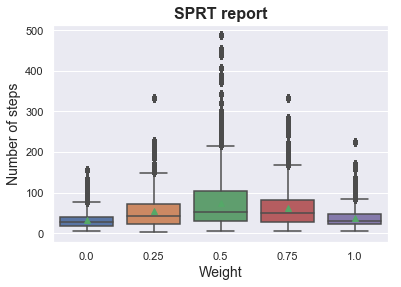

In [65]:
plot_sprt_report(sprt_report2)

In [66]:
get_num_steps_means(sprt_report2)

num_steps
weight           
0.00    32.116278
0.25    54.551001
0.50    74.489772
0.75    61.422679
1.00    37.701672

In [67]:
print_error_rates(sprt_report2)

Type I error rate: 0.018
Type II error rate: 0.010


### Conclusion
- Resulting Type I/II error rates are pretty accurate
- Lower Type I/II error rates require more iterations for SPRT test to converge
- Weight of the stratas in the sample affect number of iterations as well (pure samples with weights 0% and 100% are solved quickly, 50/50 are the hardest ratio to solve). This effect is more pronounced with more strict error rate requirements.

That's it for SPRT.

# Task 4.1: Correlation between brain size and IQ

**Task summary:**

*Inspect a brain size dataset and make a conclusion about correlation between brain size and IQ. Use Pearson correlation coefficient and the p-value for testing non-correlation.*

### Exploring the data

In [36]:
df_brain = pd.read_csv('brain.tsv', sep='\t')
df_brain.head()

Gender  FSIQ  VIQ  PIQ Weight Height  MRI_Count
0  Female   133  132  124    118   64.5     816932
1    Male   140  150  124      �   72.5    1001121
2    Male   139  123  150    143   73.3    1038437
3    Male   133  129  128    172   68.8     965353
4  Female   137  132  134    147   65.0     951545

In [37]:
df_brain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Gender       40 non-null object
FSIQ         40 non-null int64
VIQ          40 non-null int64
PIQ          40 non-null int64
Weight       40 non-null object
Height       40 non-null object
MRI_Count    40 non-null int64
dtypes: int64(4), object(3)
memory usage: 2.3+ KB


For the sake of simplicity we won't take **Weight** column (body weight) into account at all. It's unclear how to utilize it properly without specific domain knowledge.

**MRI_Count** here will stand for brain size and **FSIQ** for IQ (Full-Scale IQ Score). We don't have any null values in these columns. Let's take a look at the scatterplot and distribution plots (showing **Gender** with different colours):

In [38]:
def plot_brain_size_iq_distributions(df):
    genders = df_brain['Gender'].unique()

    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    for index, column_name in enumerate(['MRI_Count', 'FSIQ']):
        for gender in genders:
            sns.distplot(df[df.Gender == gender][column_name], ax=axes[index], rug=True)
        axes[index].legend(genders)
        axes[index].set_title('%s (by gender)' % column_name, fontsize=12, fontweight='bold')

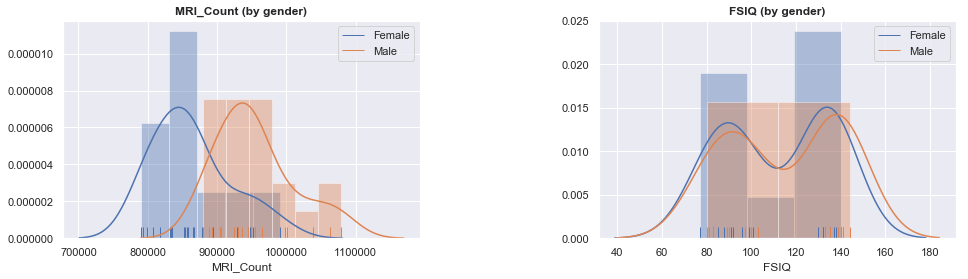

In [39]:
plot_brain_size_iq_distributions(df_brain)

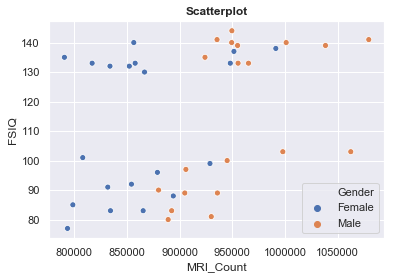

In [40]:
ax = sns.scatterplot(x="MRI_Count", y="FSIQ", hue="Gender", data=df_brain)
ax.set_title('Scatterplot', fontsize=12, fontweight='bold')
plt.show()

The takeaways from the charts are:

- There's an obvious "gap" in data between IQ values 100 and 130, most probably because this dataset is manually comprised of two smaller subsets of a population. Judging the correlation across these two groups won't give a good estimation. So we will handle these two subsets separately calling them *high-IQ* and *low-IQ* group (we will check unstratified p-values as well)
- Average male brain size is significantly bigger than female. Again, we will check unstratified and per-stratum values here.
- We can consider values in subsets to be normally distributed.
- No weird shapes on the scatterplot, using linear Pearson correlation coefficient will do fine.
- No outliers to handle here

From scatterplot examination we can expect some small FSIQ/MRI_Count correlation in all our stratas. But it is hard to tell if it is statistically significant. Let's check this in numbers. Our null hypothesis will be that correlation coefficient is zero (no correlation) and we will choose $\alpha = 0.05$ for the level of significance.

We will use SciPy library code: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html

In [41]:
def print_brain_size_iq_correlation_report(df):
    df_high  = df[df.FSIQ > 120]
    df_low  = df[df.FSIQ <= 120]
    print('Overall IQ: %.2f (p-value = %.2f)' %
          stats.pearsonr(df['FSIQ'], df['MRI_Count']))
    print('High-IQ group: %.2f (p-value = %.2f)' %
          stats.pearsonr(df_high['FSIQ'], df_high['MRI_Count']))
    print('Low-IQ group: %.2f (p-value = %.2f)' %
          stats.pearsonr(df_low['FSIQ'], df_low['MRI_Count']))

### Sample 1: all genders

In [42]:
print_brain_size_iq_correlation_report(df_brain)

Overall IQ: 0.36 (p-value = 0.02)
High-IQ group: 0.55 (p-value = 0.01)
Low-IQ group: 0.53 (p-value = 0.02)


### Sample 2: male subset

In [43]:
print_brain_size_iq_correlation_report(df_brain[df_brain.Gender == 'Male'])

Overall IQ: 0.50 (p-value = 0.03)
High-IQ group: 0.24 (p-value = 0.51)
Low-IQ group: 0.71 (p-value = 0.02)


### Sample 3: female subset

In [44]:
print_brain_size_iq_correlation_report(df_brain[df_brain.Gender == 'Female'])

Overall IQ: 0.33 (p-value = 0.16)
High-IQ group: 0.36 (p-value = 0.31)
Low-IQ group: 0.43 (p-value = 0.22)


### Conclusion

- Per-stratum p-values (by Gender and High/Low IQ subsets) generally does not indicate statistically significant correlation between brain size and intelligence. The only exception is Male/LowIQ stratum which gives *p-value* as low as 0.02.
- Unstratified p-values report significant correlation but these values are unreliable

But using *p-value* for such tiny datasets doesn't make any sense anyway.

So much for the big brain!

# Task 4.2: Car preferences among men and women

**Task summary:**

*Examine preferences for cars among men and women and investigate the extent to which they are gender-specific. Use chi-square test of independence of variables in a contingency table.*

From the dataset description we can figure out the list of columns actually related to car preferences 
- **PreferCar** -		Preferred car, coded to size of car 1=small, 2=medium, 3=large
- **Car15K** -		Preferred type of car if cost $15000, 1=small new car; 2=large second-hand car
- **Reason** -		1=safety, 2=reliability, 3=cost, 4=performance, 5=comfort, 6=looks
- **Cost** -		How important is cost when buying a car? 1=not important, 2=little importance, 3=important, 4=very important
- **Reliable** -	How important is reliability ...?
- **Perform** -		How important is performance ...?
- **Fuel** -		How important is fuel consumption ...?
- **Safety** -		How important is safety ...?
- **AC/PS** -		How important is air conditioning/power steering ...?
- **Park** -		How important is ease of parking ...?
- **Room** -	 	How important is space/roominess ...?
- **Doors** -	 	How important is the number of doors ...?
- **Prestige** -	How important is prestige/style ...?
- **Colour** -	 	How important is colour ...?

Gender is encoded in **Sex** column (1=female, 2=male).

In [45]:
GENDER_COLUMN = 'Sex'
PREFERENCE_COLUMNS = [
    'PreferCar', 'Car15K', 'Reason', 'Cost', 'Reliable', 'Perform', 
    'Fuel', 'Safety', 'AC/PS', 'Park', 'Room', 'Doors', 'Prestige',
    'Colour',
]

In [46]:
df_carprefs = pd.read_csv('carprefs.tsv', sep='\t')[[GENDER_COLUMN] + PREFERENCE_COLUMNS]
df_carprefs.head()

Sex  PreferCar  Car15K  Reason  Cost  Reliable  Perform  Fuel  Safety  \
0    2          2       2       1     3         4        3     3       3   
1    1          1       1       1     4         4        4     4       4   
2    2          3       2       5     3         3        3     3       3   
3    1          2       2       1     2         3        3     3       4   
4    1          2       1       6     3         3        4     3       3   

   AC/PS  Park  Room  Doors  Prestige  Colour  
0      3     3     3      3         3       2  
1      3     4     4      2         3       3  
2      3     3     3      3         3       3  
3      3     3     3      3         1       3  
4      2     3     3      2         3       3

In [47]:
df_carprefs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 15 columns):
Sex          300 non-null int64
PreferCar    300 non-null int64
Car15K       300 non-null int64
Reason       300 non-null int64
Cost         300 non-null int64
Reliable     300 non-null int64
Perform      300 non-null int64
Fuel         300 non-null int64
Safety       300 non-null int64
AC/PS        300 non-null int64
Park         300 non-null int64
Room         300 non-null int64
Doors        300 non-null int64
Prestige     300 non-null int64
Colour       300 non-null int64
dtypes: int64(15)
memory usage: 35.2 KB


All the columns we're interested in are already categorical and ready for building contingency table. No missing values to handle.

Let's pair all preference columns with gender and for all such pair build contingency tables and calculate chi2-statistic and p-value. Our null hypothesis will be that specific preference is uncorrelated with gender and we will choose  α=0.05  for the level of significance when interpreting the results.

We will use SciPy library:
https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html

In [48]:
def generate_carprefs_correlation_report(df, pref_columns, gender_column, alpha=0.05):
    """Generate correlation report for preference columns using chi-squared statistic. """
    prefs = []

    for col in pref_columns:
        # Build contingency table
        tab = pd.crosstab(df_carprefs[gender_column], df_carprefs[col])
        # Calculate chi2 statistic and corresponding p-value
        chi2, pvalue, *_ = stats.chi2_contingency(tab)
        prefs.append({
            'column': col,
            'chi2': chi2,
            'pvalue': pvalue,
            'reject_h0': pvalue <= alpha,
        })
    pref_report = pd.DataFrame(prefs, index=[x['column'] for x in prefs])
    return pref_report.sort_values(by='pvalue', ascending=False)

In [49]:
generate_carprefs_correlation_report(df, PREFERENCE_COLUMNS, GENDER_COLUMN)

chi2     column        pvalue  reject_h0
Prestige    1.891248   Prestige  5.952825e-01      False
Doors       3.087892      Doors  3.782715e-01      False
Room        4.210730       Room  2.395898e-01      False
Colour      5.261162     Colour  1.536425e-01      False
Reliable    6.492159   Reliable  3.892652e-02       True
Cost        8.666070       Cost  3.407647e-02       True
Fuel        9.014145       Fuel  2.910341e-02       True
Perform     9.245212    Perform  2.620222e-02       True
AC/PS      12.198220      AC/PS  6.734089e-03       True
Car15K      7.721525     Car15K  5.456630e-03       True
PreferCar  17.507848  PreferCar  5.555699e-04       True
Reason     24.033907     Reason  2.138796e-04       True
Park       32.746600       Park  3.642431e-07       True
Safety     33.894370     Safety  2.085566e-07       True

**Conclusion**
- There are four fields for which we can't reject null hypothesis - **Prestige**, **Doors**, **Roominess**, **Colour**. No wonder what we got for prestige here.
- We can reject null hypothesis for all other fields. *p-value* here varies greatly, correlations for **Safety** and **Park** are the most pronounced.